In [2]:
import numpy as np
import networkx as nx
from collections import defaultdict
import time

%matplotlib notebook
import matplotlib.pyplot as plt
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
import sys
sys.setrecursionlimit(10 ** 5)

## Генераторы графов

In [4]:
# функция возвращает случайный простой граф в моделе Gnp 
# вероятность ребра p = 2*m/(n*(n-1)), чтобы среденее число ребер было = m
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnp_graph(n, m, seed=42):
    edge_p = 2*m/(n*(n-1))
    g = nx.random_graphs.fast_gnp_random_graph(n,edge_p,seed)

    return nx.convert.to_dict_of_lists(g)

In [5]:
# функция возвращает случайный простой граф в моделе Gnm 
# структура хранения - список смежности, реализованный через словарь (хеш-таблица) списков 
# ребра представляют собой tuple двух вершин
def get_random_simple_Gnm_graph(n, m, seed=42):
    g = nx.random_graphs.gnm_random_graph(n,m,seed)

    return nx.convert.to_dict_of_lists(g)

# Алгоритмы сортировки

In [6]:
# поразрядная, карманная и быстрая сортировки
# возвращают итоговую перестановку эелементов массива A
# для того, чтобы можно было переставить элементы в любом другом массиве

# С++ имплементации из pybind11 обертки
from sortings import radix_argsort, bucket_argsort, quick_argsort

# Алгоритмы для поиска мостов

In [7]:
def get_edge_name(a, b):
        if a > b:
            return (b, a)
        else:
            return (a, b)

# детерминированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков
# выход представляет собой список ребер, являющихся мостами 
def compute_bridges_determ(adj_list):
    global color, tst, metric, counter, bridges
    n = len(adj_list)
    color = np.zeros(shape=(n,), dtype=bool)
    counter = 1
    tst = np.empty(shape=(n,), dtype=np.int32)
    metric = np.empty(shape=(n,), dtype=np.int32)
    bridges = []

    def dfs(v, p=-1):
        global color, tst, metric, counter, bridges
        color[v] = True
        tst[v] = counter
        metric[v] = tst[v]
        counter += 1
        for u in adj_list[v]:
            if (u == p):
                continue
            if color[u]:
                metric[v] = min([metric[v], tst[u]])
            else:
                dfs(u, v)
                metric[v] = min([metric[v], metric[u]])
                if (metric[u] > tst[v]):
                    bridges.append(get_edge_name(v, u))
    
    for i in range(n):
        if not color[i]:
            dfs(i)
    
    return bridges

In [8]:
# pybind11 extension with C++ functions
from random_bits import get_random_numbers, cxor

In [9]:
from timeit import default_timer as timer

In [10]:
def compute_edge_values(adj):
    global color, solved_vertices

    if isinstance(adj, nx.classes.graph.Graph):
        adj_list = nx.convert.to_dict_of_lists(adj)
    else:
        adj_list = adj
    
    edges_dict = {}
    for v in adj_list:
        for u in adj_list[v]:
            edges_dict[get_edge_name(u, v)] = False
    
    
    n = len(adj_list)
    color = np.zeros(shape=(n,), dtype=bool)
    
    def dfs(v, p=-1):
        global color
        color[v] = True
        for u in adj_list[v]:
            if (u == p):
                continue
            if not color[u]:
                edges_dict[get_edge_name(u, v)] = True
                dfs(u, v)
    
    for i in range(n):
        if not color[i]:
            dfs(i)
    
    n_random = 0
    for uv in edges_dict:
        if not edges_dict[uv]:
            n_random += 1
    random_numbers = get_random_numbers(n_random)
    
    i_random = 0
    edge_nums = {}
    for uv in edges_dict:
        if not edges_dict[uv]:
            edge_nums[uv] = random_numbers[i_random]
            i_random += 1
    
    solved_vertices = np.zeros(shape=(n,), dtype=bool)
    
    def solve(v):
        global solved_vertices
        
        if solved_vertices[v]:
            return
        x_counter = 0
        x_edge = None
        for u in adj_list[v]:
            if edges_dict[get_edge_name(u, v)]:
                x_counter += 1
                if x_counter > 1:
                    break
                x_edge = get_edge_name(u, v)
        if x_counter > 1 or x_counter == 0:
            return
        prev_uint = 0
        for u in adj_list[v]:
            if not edges_dict[get_edge_name(u, v)]:
                prev_uint = cxor(prev_uint, edge_nums[get_edge_name(u, v)])
        edges_dict[x_edge] = False
        edge_nums[x_edge] = prev_uint
        solved_vertices[v] = True
        for u in adj_list[v]:
            if not solved_vertices[u]:
                solve(u)
    
    for v in adj_list:
        solve(v)

    return edge_nums

In [11]:
# рандомизированный алгоритм для поиска мостов
# на вход поступает граф представленный списком смежности
# саписок представлен как словарь(хеш-таблица) списков 
# выход представляет собой список ребер, являющихся мостами с большой вероятностью
def compute_bridges_rand(adj_list):
    edge_nums = compute_edge_values(adj_list)
    
    bridges = []
    for uv in edge_nums:
        if edge_nums[uv] == 0:
            bridges.append(uv)
    return bridges

In [12]:
# рандомизированный алгоритм для поиска 2-мостов
#
# на вход поступает граф представленный списком смежности и алгоритм сортировки для меток на ребрах
# саписок представлен как словарь(хеш-таблица) списков 
#
# выходом алгоритма является список списков ребер
# в каждом списке любая пара ребер должна с высокой вероятностью образовывать 2-мост
# например, если выходом является спискок [[e1, e2, e3],[e4, e5]]
# то с высокой вероятностью 2-мостами будут пары ребер: (e1,e2), (e1,e3), (e2,e3), (e4,e5)
# ребра здесь это пары вершин типа e1 = (1,2)
def compute_2bridges_rand(adj_list, sort_fun):
    edge_nums = compute_edge_values(adj_list)
    if len(edge_nums) == 0:
        return []
    edges_list = list(edge_nums.keys())
    
    edge_values = list(edge_nums.values())
    idx = sort_fun(edge_values)
    sorted_edge_values = list(np.array(edge_values, dtype=np.uint64)[idx])
    
    two_bridges = []
    current_values = [sorted_edge_values[0], ]
    current_idx = [idx[0], ]
    for i in range(1, len(idx)):
        if sorted_edge_values[i] == current_values[-1]:
            current_values.append(sorted_edge_values[i])
            current_idx.append(idx[i])
        else:
            if len(current_values) != 1:
                two_bridges.append([])
                for k in current_idx:
                    two_bridges[-1].append(edges_list[k])
            current_values, current_idx = [sorted_edge_values[i], ], [idx[i], ]
    return two_bridges

# Стресс тесты

In [13]:
def stress_test_bridges_determ(n, m, iterations_num=1000):
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_determ(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > 0:
      raise Exception(f"Неверное решение в детерминированном алгоритме поиска мостов, n: {n}, m: {m}, seed: {i}")
  print(f"Стресс тест для детерминированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [14]:
def stress_test_bridges_rand(n, m, iterations_num=1000):
  exp_err = m * (1/ (2**64))
  for i in range(iterations_num):
    G = get_random_simple_Gnp_graph(n, m, i)
    briges_test = compute_bridges_rand(G)
    bridges_true = set(nx.algorithms.bridges(nx.Graph(G)))
    diff = list(bridges_true.symmetric_difference(briges_test))
    if len(diff) > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {len(diff)}, seed: {i}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, iterations_num: {iterations_num}")
    

In [15]:
def stress_test_2bridges_rand(n, m, sort, iterations_num=1000):
  exp_err = (m*(m-1)/2) * (1/ (2**64))
  for iteration in range(iterations_num):
    err_num = 0
    G = nx.Graph(get_random_simple_Gnp_graph(n, m, iteration))
    bridges_test = compute_2bridges_rand(G,sort)
    for edge_group in bridges_test:
      for e1 in range(len(edge_group)):
        for e2 in range(e1+1,len(edge_group)):
          G_with_deleted_2bridge = G.copy()
          G_with_deleted_2bridge.remove_edge(*edge_group[e1])
          G_with_deleted_2bridge.remove_edge(*edge_group[e2])
          if nx.connected.number_connected_components(G) == nx.connected.number_connected_components(G_with_deleted_2bridge):
            ++err_num
    if err_num > exp_err:
      raise Exception(f"Число ошибок в рандомизированном алгоритме поиска мостов превышено, n: {n}, m: {m}, errors_num: {err_num}, sort: {sort}, seed: {iteration}")
  print(f"Стресс тест для рандомизированного поиска мостов пройден!, n: {n}, m: {m}, , sort: {sort}, iterations_num: {iterations_num}")

In [16]:
stress_test_bridges_determ(1000, 500, 100)
stress_test_bridges_rand(1000, 500, 100)
stress_test_2bridges_rand(250, 50, radix_argsort, 100)
stress_test_2bridges_rand(250, 50, bucket_argsort, 100)
stress_test_2bridges_rand(250, 50, quick_argsort, 100)

Стресс тест для детерминированного поиска мостов пройден!, n: 1000, m: 500, iterations_num: 100
Стресс тест для рандомизированного поиска мостов пройден!, n: 1000, m: 500, iterations_num: 100
Стресс тест для рандомизированного поиска мостов пройден!, n: 250, m: 50, , sort: <built-in method radix_argsort of PyCapsule object at 0x7ffa03311ed0>, iterations_num: 100
Стресс тест для рандомизированного поиска мостов пройден!, n: 250, m: 50, , sort: <built-in method bucket_argsort of PyCapsule object at 0x7ffa680b73f0>, iterations_num: 100
Стресс тест для рандомизированного поиска мостов пройден!, n: 250, m: 50, , sort: <built-in method quick_argsort of PyCapsule object at 0x7ffa0331e1b0>, iterations_num: 100


# Юнит тесты

In [17]:
def bridges_unit_test(G):
  test_bridges_determ = compute_bridges_determ(nx.convert.to_dict_of_lists(G))
  test_bridges_rand = compute_bridges_rand(nx.convert.to_dict_of_lists(G))
  true_bridges = set(nx.algorithms.bridges(nx.Graph(G)))
  determ_diff = list(true_bridges.symmetric_difference(test_bridges_determ))
  rand_diff = list(true_bridges.symmetric_difference(test_bridges_rand))
  assert len(determ_diff) == 0
  assert len(rand_diff) == 0

In [18]:
def two_bridges_unit_test(G, sort_fun):
  test_bridges = compute_2bridges_rand(nx.convert.to_dict_of_lists(G), sort_fun)
  for edge_group in test_bridges:
      for e1 in range(len(edge_group)):
        for e2 in range(e1+1,len(edge_group)):
          G_with_deleted_2bridge = G.copy()
          G_with_deleted_2bridge.remove_edge(*edge_group[e1])
          G_with_deleted_2bridge.remove_edge(*edge_group[e2])
          assert nx.connected.number_connected_components(G) < nx.connected.number_connected_components(G_with_deleted_2bridge)

In [19]:
bridges_unit_test(nx.generators.cycle_graph(10))
bridges_unit_test(nx.generators.path_graph(10))
bridges_unit_test(nx.generators.empty_graph(10))
bridges_unit_test(nx.generators.wheel_graph(10))
bridges_unit_test(nx.generators.trivial_graph())
bridges_unit_test(nx.generators.balanced_tree(3,3))
print("Все юнит тесты для поиска мостов пройдены успешно!")

sort_functions = [radix_argsort, bucket_argsort, quick_argsort]
for sort_fun in sort_functions:
  two_bridges_unit_test(nx.generators.cycle_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.path_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.empty_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.wheel_graph(10), sort_fun)
  two_bridges_unit_test(nx.generators.trivial_graph(), sort_fun)
  two_bridges_unit_test(nx.generators.balanced_tree(3,3), sort_fun)
print("Все юнит тесты для поиска 2-мостов пройдены успешно!")

Все юнит тесты для поиска мостов пройдены успешно!
Все юнит тесты для поиска 2-мостов пройдены успешно!


# Графики

In [20]:
def check_time(f, *args):
    start = timer()
    f(*args)
    return timer() - start

In [21]:
def plot_bridges(m_fun, start = 200, step = 200, end = 10000, number_of_retryes = 3):
  _x, determ_Gnp_y, determ_Gnm_y, rand_Gnp_y, rand_Gnm_y = [], [], [], [], []
  for n in range(start,end,step):
    m = m_fun(n)
    time_Gnp_determ = 0.
    time_Gnp_rand = 0.
    time_Gnm_determ = 0.
    time_Gnm_rand = 0.
    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_Gnp_determ += check_time(compute_bridges_determ, g)
      time_Gnp_rand += check_time(compute_bridges_rand, g)
      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_Gnm_determ += check_time(compute_bridges_determ, g)
      time_Gnm_rand += check_time(compute_bridges_rand, g)
    time_Gnp_determ /= number_of_retryes
    time_Gnp_rand /= number_of_retryes
    time_Gnm_determ /= number_of_retryes
    time_Gnm_rand /= number_of_retryes
    _x.append(n)
    determ_Gnp_y.append(time_Gnp_determ)
    rand_Gnp_y.append(time_Gnp_rand)
    determ_Gnm_y.append(time_Gnm_determ)
    rand_Gnm_y.append(time_Gnm_rand)

  plt.plot(_x, determ_Gnp_y, label = "determ Gnp")
  plt.plot(_x, rand_Gnp_y, label = "rand Gnp")
  plt.plot(_x, determ_Gnm_y, label = "determ Gnm")
  plt.plot(_x, rand_Gnm_y, label = "rand Gnm")
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (1000,1000))
  plt.show()

In [22]:
def plot_2bridges(m_fun, start = 200, step = 200, end = 5000, number_of_retryes = 3):
  _x = []
  quick_Gnp, radix_Gnp, bucket_Gnp, standard_Gnp = [], [], [], []
  quick_Gnm, radix_Gnm, bucket_Gnm, standard_Gnm = [], [], [], []

  for n in range(start,end,step):
    m = m_fun(n)
    time_quick_Gnp, time_radix_Gnp, time_bucket_Gnp, time_standard_Gnp = 0., 0., 0., 0.
    time_quick_Gnm, time_radix_Gnm, time_bucket_Gnm, time_standard_Gnm = 0., 0., 0., 0.

    for exp_num in range(number_of_retryes):
      g = get_random_simple_Gnp_graph(n,m,exp_num)
      time_quick_Gnp += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnp += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnp += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnp += check_time(compute_2bridges_rand,g,np.argsort)

      g = get_random_simple_Gnm_graph(n,m,exp_num)
      time_quick_Gnm += check_time(compute_2bridges_rand,g,quick_argsort)
      time_bucket_Gnm += check_time(compute_2bridges_rand,g,bucket_argsort)
      time_radix_Gnm += check_time(compute_2bridges_rand,g,radix_argsort)
      time_standard_Gnm += check_time(compute_2bridges_rand,g,np.argsort)

    time_quick_Gnp /= number_of_retryes
    time_bucket_Gnp /= number_of_retryes
    time_radix_Gnp /= number_of_retryes
    time_standard_Gnp /= number_of_retryes

    time_quick_Gnm /= number_of_retryes
    time_bucket_Gnm /= number_of_retryes
    time_radix_Gnm /= number_of_retryes
    time_standard_Gnm /= number_of_retryes

    _x.append(n)

    quick_Gnp.append(time_quick_Gnp)
    bucket_Gnp.append(time_bucket_Gnp)
    radix_Gnp.append(time_radix_Gnp)
    standard_Gnp.append(time_standard_Gnp)

    quick_Gnm.append(time_quick_Gnm)
    bucket_Gnm.append(time_bucket_Gnm)
    radix_Gnm.append(time_radix_Gnm)
    standard_Gnm.append(time_standard_Gnm)

  plt.plot(_x, quick_Gnp, label = "quick Gnp")
  plt.plot(_x, bucket_Gnp, label = "bucket Gnp")
  plt.plot(_x, radix_Gnp, label = "radix Gnp")
  plt.plot(_x, standard_Gnp, label = "standard Gnp")

  plt.plot(_x, quick_Gnm, label = "quick Gnm")
  plt.plot(_x, bucket_Gnm, label = "bucket Gnm")
  plt.plot(_x, radix_Gnm, label = "radix Gnm")
  plt.plot(_x, standard_Gnm, label = "standard Gnm")

  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
  plt.xlabel('number of vertices')
  plt.ylabel('time s.')
  plt.title(f"Эксперименты с 2-мостами, start: {start}, step: {step}, end: {end},\n \
  number of retryes: {number_of_retryes}, edges density: {n/m}")
  #plt.figure(figsize= (100000,100000))
  plt.show()

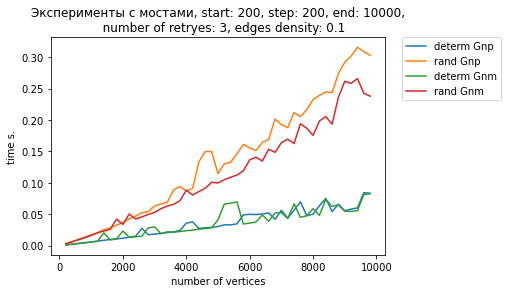

Total time: 68.72418786799972


In [22]:
print(f"Total time: {check_time(plot_bridges, lambda n: 10*n)}")

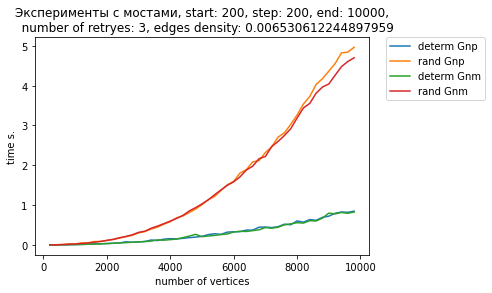

Total time: 767.6564324350002


In [23]:
print(f"Total time: {check_time(plot_bridges, lambda n: n**2/64)}")

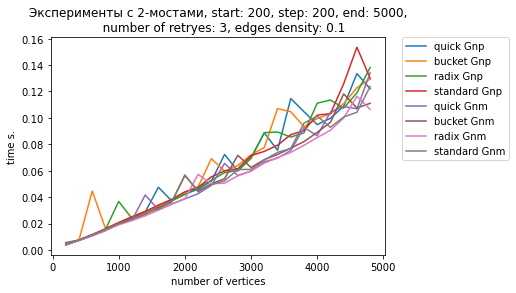

Total time: 39.0457133029995


In [24]:
print(f"Total time: {check_time(plot_2bridges, lambda n: 10*n)}")

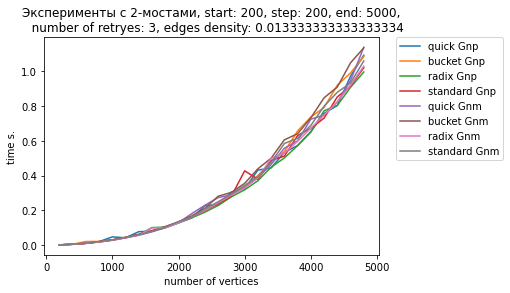

Total time: 220.67411811800048


In [23]:
print(f"Total time: {check_time(plot_2bridges, lambda n: n**2/64)}")